# Understanding Disagreements and Corrections using RSA

---

    <world knowledge> "§ 14-309.8.  Limit on sessions. The number of sessions of bingo conducted or sponsored by an exempt organization shall be limited to two sessions per week and such sessions must not exceed a period of five hours each per session." [US NC legislation](https://www.ncleg.net/EnactedLegislation/Statutes/HTML/ByArticle/Chapter_14/Article_37.html)
    
    <prosecution> "The defendant played at the bingo event for 7 hours straight."
    <defense> "At the mayfair."

---
This notebook is supposed to be a 1:1 adaptation of the [RSA-Hyperbole Pyro Example](http://pyro.ai/examples/RSA-hyperbole.html)

It is also meant to serve as a functional (as opposed to object oriented) but otherwise identical implementation as the one in comp_implt.py

---

Correcting a specific detail of what someone said is a common use of language possibly requiring logical inference during interpretation. I extend the RSA Model as used in [the Pyro Example](http://pyro.ai/examples/RSA-hyperbole.html) to include a logical theorem prover and allow non-literal probabilistic interpretation of corrections.

In [18]:
#first some imports
import torch
torch.set_default_dtype(torch.float64)  # double precision for numerical stability

import collections
import argparse

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from search_inference import factor, memoize
from phrasal import *
from helpers import *
rpc = wrapped_rpc

The domain for this example will be beliefs consisting of beliefs in first order logic form. More specifically, we will use a Neo-Davidsonian Event representation, so the event

    The chicken crossed the road at an intersection.
is normalized to:

    exists e. cross(e, chicken, road) & agn(e, chicken) & pat(e, road) & loc(e, intersection)
    
 
This representation lends itself both to logical inference about meaning and is compositionally built up so, associated attributes can be added together.
The implementation comes in the form a phrase class that provides an elementary cost attribute and builds up phrases incrementally from constituents. 
Priors here could be adapted from experimental data.

In the example, we are in court after Brutus murdered Caesar; two parties have different beliefs about how the event went down, one side first makes a statement how the event went down and then the other side interrupts (or decides not to). To avoid confusion it should be emphasized that the first person is the _Listener_ and the second person is the _Speaker_ as the Speech Act in focus is the correction.


A bit of prior setup is needed for this before we can turn to the RSA model. The world knowledge is provided in a list of FOL expressions. $k_{1-4}$ are specific conditions for punishment.

In [19]:
import nltk
expr = nltk.sem.Expression.fromstring

k1 = expr("all x.((exists e.(kill(e,x,y) & in(e,rome))) -> should_hang(x))")#ki    lling in forum very illegal
k2 = expr("all x.((exists e.(kill(e,x,y))) -> mean(x))")
k3 = expr("all x.((exists e.(agn(e,x) & ins(e,knife))) -> should_be_lashed(x))"    )#using knife is slightly bad
k4 = expr("all x.((exists e.(loc(e,rubicon) & ins(e,paddle))) -> great(x))")#us    ing paddle at rubicon is awesome

f1 = expr("all e.(loc(e,forum) -> in(e, rome))")
f2 = expr("all e.(loc(e,rubicon) -> -in(e, rome))")
f3 = expr("all e.(stab(e,x,y) -> kill(e,x,y))")

swk = [k1,k2,k3,k4,f1,f2,f3]

The above shared world knowledge (swk) is shared in the sense that each of the two interlocutors 
1. knows these facts
2. knows the other knows them  
  
  
the listener furthermore also  
3. knows the speaker knows the listener knows them

In contrast, the following beliefs are specifically pertaining to the discussed event and may differ between the two.

In [20]:
from court import *

beliefs = [
         phrase([brutus, stab, caesar, forum, knife]),#prosecution belief
         phrase([brutus, stab, caesar, forum]),
         phrase([brutus, stab, caesar, knife]),
         phrase([brutus, stab, caesar, forum, knife]),
         phrase([brutus, stab, caesar, forum, sword]),
         phrase([brutus, stab, caesar, forum, knife]),
         phrase([brutus, stab, caesar, rubicon, sword]), 
         phrase([brutus, stab, caesar, rubicon]), 
         phrase([brutus, stab, caesar, sword]), 
         phrase([brutus, stab, caesar, sword, rubicon]),#defense belief
         phrase([brutus, stab, caesar, rubicon, knife]), 
         phrase([brutus, stab, caesar, rubicon, sword]), 
         phrase([caesar_ag, stab, brutus_pat, forum, knife]),
         phrase([brutus, stab, caesar, rubicon, knife, fun]),
         phrase([brutus, stab, caesar, rubicon, sword, others, fun]),
         phrase([brutus, row, boat, rubicon, paddle]),
         phrase([someone_else, stab, caesar, rubicon, knife])
      ]

def belief_prior(B): #over list
    ix = pyro.sample("belief", dist.Categorical(probs=torch.ones(len(B))/len(B)))
    return B[ix]

# change at will: 
listener_belief = beliefs[0]
speaker_belief = beliefs[9]

Recall the $k_{1-4}$ which were introduced above; these are the respective conditions for the questions under discussion (QUDs) discussed by our prosecution and defense.

In [15]:
quds = {
        "hang": expr("should_hang(brutus)"),
        "mean": expr("mean(brutus)"),
        "lashed": expr("should_be_lashed(brutus)"),
        "great": expr("great(brutus)"),
}

def qud_prior(quds): #over dict
    keys = list(quds.keys())
    ix = pyro.sample("qud", dist.Categorical(probs=torch.ones(len(keys))/len(keys)))
    qud = keys[ix.item()]
    return qud

---
### The RSA Literal Listener

We can now turn to the literal listener ($L0$), which begins the chain of inference in the RSA model. $L0$ replaces the utterance in the listener belief according to the role the replacement has, then runs logical inference and finally produces a distribution over _beliefs_ 

	this Search.run() was for:  <function L0 at 0x7fbbbc6270d0>
HashingMarginal instantiated for trace_dist
trace_dist:  <search_inference.Search object at 0x7fbbbc43e128>
sites:  None
current self trace_dist model? <function L0 at 0x7fbbbc6270d0>
current self distribution? Categorical(logits: torch.Size([17]))
&&&&&&&&&&
log_prob values in HashingMarginal:
d:  Categorical(logits: torch.Size([17]))
values_map:  [(8777898892029, 5), (8777898892022, 4), (8777898891882, 4), (8777898276051, 5), (8777898276079, 5), (8777898276058, 5), (-9223363259084143612, 5), (-9223363259072810187, 4), (-9223363259086071643, 4), (-9223363259086071804, 5), (8777768704015, 5), (8777768704162, 5), (8777768704232, 5), (-9223363259086071580, 6), (-9223363259088692718, 7), (-9223363259086440353, 5), (8777766083262, 5)]
val:  exists e.agn(e,brutus) & stab(e,brutus,caesar) & pat(e,caesar) & loc(e,forum) & ins(e,knife)
value_hash:  8777898892029
current self trace_dist model? <function L0 at 0x7fbbbc6270d0>
current s

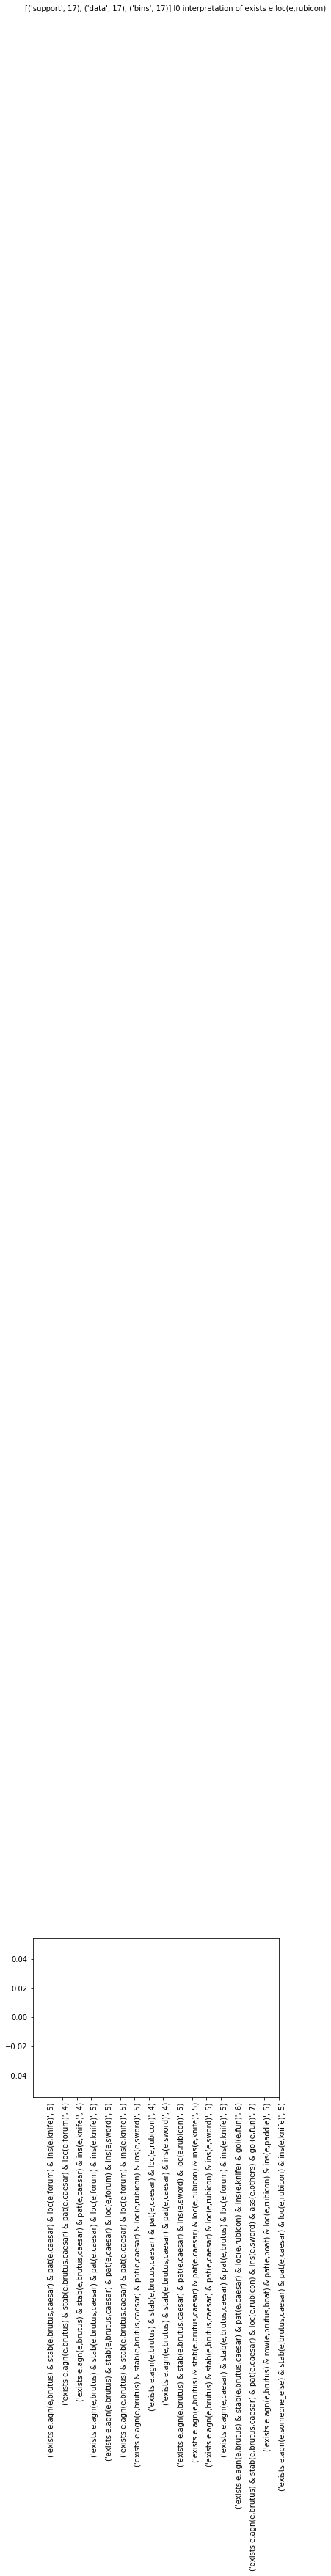

In [14]:
@Memo
@Marginal
def L0(correction):

    interjector_belief=belief_prior(beliefs) #state_prior() in RSAhyperb
    replacement = listener_belief.replace_constituents_in_utt(correction)
    if not type(correction) == NULL_Utt:
        added_expr = replacement
    else:
        added_expr = listener_belief
    evaluation = rpc(goal=interjector_belief.L(), assumptions=swk+[added_expr.L()]).prove()

    factor("literal meaning", 0. if evaluation else float("-inf"))
    
    return interjector_belief

correction = phrase([rubicon])   

l0_dist = L0(correction)
plotter(l0_dist, output="show", addinfo="l0 interpretation of "+str(correction))

The above plot shows the literal listeners interpretation of the utterance "At the rubicon.".

---
### The RSA Pragmatic Speaker
Is called $S_1$ and considers $L_0$'s interpretation of the utterances in $L_1$'s utterance prior. The utterance prior is reduced for computational tractability to the power set of the difference in assigned roles between the $L_0$ statement and $S_1$'s own belief. So, for example:

    <prosecution utterance> "exists e.agn(e,brutus) & stab(e,brutus,caesar) & pat(e,caesar) & loc(e,forum) & ins(e,knife)"
    <defense belief> "exists e.agn(e,brutus) & stab(e,brutus,caesar) & pat(e,caesar) & ins(e,sword) & loc(e,rubicon)"
    
    <utterance_prior return values>
        1.
        2.
        3.
        4.

In [17]:
def utterance_prior(given_full_belief):
    """
    My utterance prior is a function of the given belief AND also of speaker state/belief !
    This is unlike in other RSA examples and a more general but far costlier to calculate prior
    should be put in place here
    
    As this utterance prior relies on speaker state/belief it may seem like cheating to use 
    this in pragmatic listener interpretation later on, however
    """
    both_assigned = set(defense_belief.assed.keys()).intersection(set(given_full_belief.assed.keys()))
    diff_roles = []
    for role in both_assigned:
        if defense_belief.assed[role] != given_full_belief.assed[role]:
            diff_roles.append(role)
    diff = []
    for const in defense_belief.elems:
        for r in diff_roles:
            if const.field == r:
                diff += [const]
    d = phrase(diff) #difference in beliefs phrased fully

    possible_changers = d.sub_utterances()
    changerLogits = -torch.tensor([phr.cost for phr in possible_changers], dtype=torch.float64) 
    ix = pyro.sample("utterance",dist.Categorical(logits=changerLogits))
    
    return possible_changers[ix]

utterance_prior()

Now we define a version of the RSA speaker that only produces *relevant* information for the literal listener. We define relevance with respect to a Question Under Discussion (QUD) -- this can be thought of as defining the speaker's current attention or topic.

The speaker is defined mathematically by:

$$P_S(u|s,q) \propto \left[ \sum_{w'} \delta_{q(w')=q(w)} P_\text{Lit}(w'|u) p(u) \right]^\alpha $$

To implement this as a probabilistic program, we start with a helper function `project`, which takes a distribution over some (discrete) domain and a function `qud` on this domain. It creates the push-forward distribution, using `Marginal` (as a Python decorator). The speaker's relevant information is then simply information about the state in this projection.

In [ ]:
@Marginal
def project(dist,qud):
    v = pyro.sample("proj",dist)
    return qud_fns[qud](v)

@Marginal
def literal_listener(utterance):
    state=state_prior()
    factor("literal_meaning", 0. if meaning(utterance, state.price) else -999999.)
    return state



@Marginal
def speaker(state, qud):
    alpha = 1.
    qudValue = qud_fns[qud](state)
    with poutine.scale(scale=torch.tensor(alpha)):
        utterance = utterance_prior()
        literal_marginal = literal_listener(utterance)
        projected_literal = project(literal_marginal, qud)
        pyro.sample("listener", projected_literal, obs=qudValue)
    return utterance

@Marginal
def pragmatic_listener(utterance):
    state = state_prior()
    qud = qud_prior()
    speaker_marginal = speaker(state, qud)
    pyro.sample("speaker", speaker_marginal, obs=utterance)
    return state


The possible QUDs capture that the speaker may be attending to the price, her affect, or some combination of these. We assume a uniform QUD prior.

Now we specify the utterance meanings (standard number word denotations: "N" means exactly $N$) and a uniform utterance prior. 

In [ ]:
def utterance_prior():
    utterances = [50, 51, 500, 501, 1000, 1001, 5000, 5001, 10000, 10001]
    ix = pyro.sample("utterance", dist.Categorical(probs=torch.ones(len(utterances)) / len(utterances)))
    return utterances[ix]

def meaning(utterance, price):
    return utterance == price

OK, let's see what number term this speaker will say to express different states and QUDs.

In [ ]:
#silly plotting helper:


# plot_dist( speaker(State(price=50, arousal=False), "arousal") )
# plot_dist( speaker(State(price=50, arousal=True), "price") )


Try different values above! When will the speaker favor non-literal utterances?

Finally, the pragmatic listener doesn't know what the QUD is and so jointly reasons abut this and the state.

How does this listener interpret the uttered price "10,000"? On the one hand this is a very unlikely price *a priori*, on the other if it were true it would come with strong arousal. Altogether this becomes a plausible *hyperbolic* utterence:

## Pragmatic Halo

"It cost fifty dollars" is often interpretted as costing *around* 50 -- plausibly 51; yet "it cost fiftyone dollars" is interpretted as 51 and definitely not 50. This assymetric imprecision is often called the pragmatic halo or pragmatic slack.

We can extend the hyperole model to capture this additional non-literal use of numbers by including QUD functions that collapse nearby numbers and assuming that round numbers are slightly more likely (because they are less difficult to utter).

In [ ]:
#A helper to round a number to the nearest ten:
def approx(x, b=None):
    if b is None:
        b = 10.
    div = float(x)/b
    rounded = int(div) + 1 if div - float(int(div)) >= 0.5 else int(div)
    return int(b) * rounded

#The QUD functions we consider:
qud_fns = {
    "price": lambda state: State(price=state.price, arousal=None),
    "arousal": lambda state: State(price=None, arousal=state.arousal),
    "priceArousal": lambda state: State(price=state.price, arousal=state.arousal),
    "approxPrice": lambda state: State(price=approx(state.price), arousal=None),
    "approxPriceArousal": lambda state: State(price=approx(state.price), arousal=state.arousal),
}

def qud_prior():
    values = list(qud_fns.keys())
    ix = pyro.sample("qud", dist.Categorical(probs=torch.ones(len(values)) / len(values)))
    return values[ix]

def utterance_cost(numberUtt):
    preciseNumberCost = 10.
    return 0. if approx(numberUtt) == numberUtt else preciseNumberCost

def utterance_prior():
    utterances = [50, 51, 500, 501, 1000, 1001, 5000, 5001, 10000, 10001]
    utteranceLogits = -torch.tensor(list(map(utterance_cost, utterances)),
                                    dtype=torch.float64)
    ix = pyro.sample("utterance", dist.Categorical(logits=utteranceLogits))
    return utterances[ix]

The RSA speaker and listener definitions are unchanged:

In [ ]:
@Marginal
def literal_listener(utterance):
    state=state_prior()
    factor("literal_meaning", 0. if meaning(utterance, state.price) else -999999.)
    return state

@Marginal
def speaker(state, qud):
    alpha = 1.
    qudValue = qud_fns[qud](state)
    with poutine.scale(scale=torch.tensor(alpha)):
        utterance = utterance_prior()
        literal_marginal = literal_listener(utterance)
        projected_literal = project(literal_marginal, qud)
        pyro.sample("listener", projected_literal, obs=qudValue)
    return utterance

@Marginal
def pragmatic_listener(utterance):
    state = state_prior()
    qud = qud_prior()
    speaker_marginal = speaker(state, qud)
    pyro.sample("speaker", speaker_marginal, obs=utterance)
    return state

OK, let's see if we get the desired assymetric slack (we're only interested in the interpretted price here, so we marginalize out the arousal).

In [ ]:
@Marginal
def pragmatic_listener_price_marginal(utterance):
    return pyro.sample("pm", pragmatic_listener(utterance)).price



## Irony and More Complex Affect

In the above hyperbole model we assumed a very simple model of affect: a single dimension with two values (high and low arousal). Actual affect is best represented as a two-dimensional space corresponding to valence and arousal. Kao and Goodman (2015) showed that extending the affect space to these two dimensions immediately introduces a new usage of numbers: verbal irony in which an utterance corresponding to a high-arousal positive valence state is used to convey a high-arousal but negative valence (or vice versa). 